In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PySigmoid import *    
from functools import reduce
import operator

from sklearn.datasets import  make_circles
set_posit_env(8, 0)

In [10]:
def posify(x):
    if type(x) == np.ndarray:
        if len(x.shape) == 1:
            return np.array([Posit(y) for y in x])
        else:
            return np.array([[Posit(z) for z in y] for y in x])
    else:
        return Posit(x)
    
def sigmoid(x):
    if type(x) == np.ndarray:
        if len(x.shape) == 1:
            return np.array([(y).sigmoid() for y in x])
        else:
            return np.array([[(z).sigmoid() for z in y] for y in x])
    else:
        return (x).sigmoid()
    
def sigmoid_derivative(x):
        return x * (1 - x)
    
def fused_dot_product(a, b):
    if all(isinstance(x, Posit) for x in (a + b)):
        r = reduce(operator.add, map(lambda x, y: Quire(x) * Quire(y), a,b))
        return Posit(r)
    else:
        raise Exception("Arguments must be lists of posit")

def fused_matmult(a, b):
    zip_b = zip(*b)
    # uncomment next line if python 3 :
    zip_b = list(zip_b)
    return [[fused_dot_product(row_a, col_b) 
             for col_b in zip_b] for row_a in a]

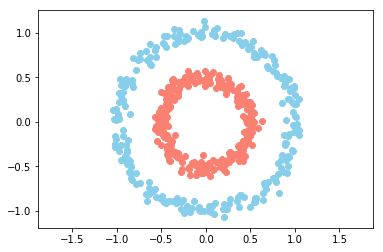

In [3]:
# CREATE THE DATASET

n = 500
p = 2

X, Y = make_circles(n_samples=n, factor=0.5, noise=0.05)

Y = Y[:, np.newaxis]
plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c='skyblue')
plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c='salmon')
plt.axis('equal')
plt.show()

In [18]:
# NEURAL LAYER CLASS

class neural_layer():
 
  def __init__(self, n_conn, n_neur, act_f, posit=False):
    np.random.seed(1)
    
    self.act_f = act_f
    
    self.b = np.random.rand(1, n_neur)      * 2 - 1
    self.W = np.random.rand(n_conn, n_neur) * 2 - 1
    if posit:
        self.b = posify(self.b)
        self.W = posify(self.W)

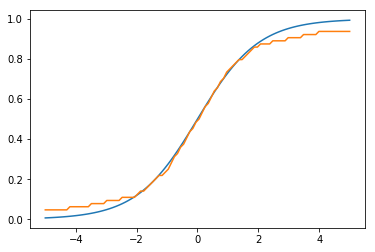

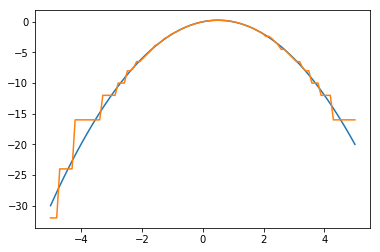

In [19]:
# ACTIVATION FUNCTIONS

sigm = (lambda x: 1 / (1 + np.e ** (-x)),
        lambda x: x * (1 - x))

sigm2 = (lambda x: sigmoid(x),
        lambda x: sigmoid_derivative(x))

relu = lambda x: np.maximum(0, x)

_x = np.linspace(-5, 5, 100)
plt.plot(_x, sigm[0](_x))
plt.plot(_x, sigm2[0](posify(_x)))

plt.figure()
plt.plot(_x, sigm[1](_x))
plt.plot(_x, sigm2[1](posify(_x)))

In [20]:
# CREATE THE NEURAL NETWORK

l0 = neural_layer(p, 4, sigm)
l1 = neural_layer(4, 8, sigm)
# ...

def create_nn(topology, act_f, posit=False):
    nn = []
  
    for l, layer in enumerate(topology[:-1]):    
        nn.append(neural_layer(topology[l], topology[l+1], act_f, posit))
    
    return nn

In [25]:
# FUNCION DE ENTRENAMIENTO

def train(neural_net, X, Y, l2_cost, lr=0.5, train=True):  
    out = [(None, X)]
  
    # Forward pass
    for l, layer in enumerate(neural_net):

        z = fused_matmult(out[-1][1], neural_net[l].W) + neural_net[l].b
        a = neural_net[l].act_f[0](z)

        out.append((z, a))

  
    if train:
        # Backward pass 
        deltas = []

        for l in reversed(range(0, len(neural_net))):
            z = out[l+1][0]
            a = out[l+1][1]

            if l == len(neural_net) - 1:
                deltas.insert(0, l2_cost[1](a, Y) * neural_net[l].act_f[1](a))
            else:
                deltas.insert(0, fused_matmult(deltas[0], _W.T) * neural_net[l].act_f[1](a))

            _W = neural_net[l].W

            # Gradient descent
            neural_net[l].b = neural_net[l].b - np.mean(deltas[0], axis=0, keepdims=True) * lr   
            neural_net[l].W = neural_net[l].W - np.array(fused_matmult(out[l][1].T, deltas[0])) * lr
      
    return out[-1][1]

topology = [p, 4, 8, 1]
neural_net = create_nn(topology, sigm)  
l2_cost = (lambda Yp, Yr: np.mean((Yp - Yr) ** 2),
           lambda Yp, Yr: (Yp - Yr))

# train(neural_net, X, Y, l2_cost, 0.5)
print("")

In [8]:
def plot_NN(i, posit = False):
    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)

    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
        for i1, x1 in enumerate(_x1):
            if posit:
                _Y[i0, i1] = train(nn_posit, posify(np.array([[x0, x1]])), posify(Y), l2_cost, train=False)[0][0]
            else:
                _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), Y, l2_cost, train=False)[0][0]

    plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
    plt.axis("equal")

    plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
    plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")
    plt.title('{} steps of training'.format(i))
    plt.savefig('8_quire/{}.png'.format(i))

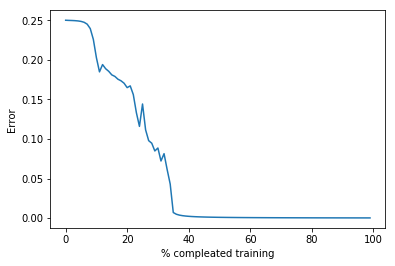

In [12]:
# VISUALIZATION & TEST

import time
from IPython.display import clear_output

neural_n = create_nn(topology, sigm)
# set_posit_env(8, 0)
# nn_posit = create_nn(topology, sigm2)

loss = []

plot_NN(0)

for i in range(1,2501):

    # Entrenemos a la red!
    pY = train(neural_n, X, Y, l2_cost, lr=0.05)
#     pY = train(nn_posit, posify(X), posify(Y), l2_cost, lr=0.05)

    if i % 25 == 0:
#         print(pY)

        loss.append(l2_cost[0](pY, Y))
        plot_NN(i)

#         res = 50

#         _x0 = np.linspace(-1.5, 1.5, res)
#         _x1 = np.linspace(-1.5, 1.5, res)

#         _Y = np.zeros((res, res))

#         for i0, x0 in enumerate(_x0):
#             for i1, x1 in enumerate(_x1):
#                 _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), Y, l2_cost, train=False)[0][0]
# #                 _Y[i0, i1] = train(nn_posit, posify(np.array([[x0, x1]])), posify(Y), l2_cost, train=False)[0][0]

#         plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
#         plt.axis("equal")

#         plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
#         plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")
#         plt.title('{} steps of training'.format(i))
#         plt.savefig('float/{}.png'.format(i))

        clear_output(wait=True)
        plt.show()
        plt.plot(range(len(loss)), loss)
        plt.xlabel('% compleated training')
        plt.ylabel('Error')
        plt.show()
#         time.sleep(0.5)  

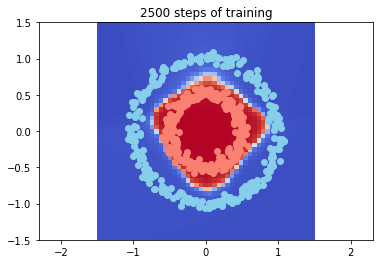

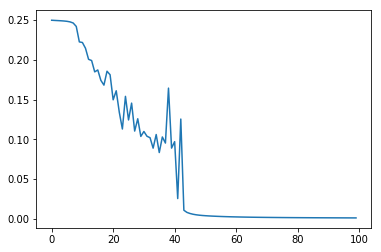

In [14]:
from IPython.display import clear_output
set_posit_env(32, 0)
nn_posit = create_nn(topology, sigm2)

loss = []
res = 50
_x0 = np.linspace(-1.5, 1.5, res)
_x1 = np.linspace(-1.5, 1.5, res)

_Y = np.zeros((res, res))

for i0, x0 in enumerate(_x0):
    for i1, x1 in enumerate(_x1):
#                 _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), Y, l2_cost, train=False)[0][0]
        _Y[i0, i1] = train(nn_posit, posify(np.array([[x0, x1]])), posify(Y), l2_cost, train=False)[0][0]

plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
plt.axis("equal")

plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")
plt.title('{} steps of training'.format(0))
plt.savefig('32/{}.png'.format(0))

for i in range(1,2501):

    # Entrenemos a la red!
#     pY = train(neural_n, X, Y, l2_cost, lr=0.05)
    pY = train(nn_posit, posify(X), posify(Y), l2_cost, lr=0.05)

    if i % 25 == 0:
#         print(pY)

#         loss.append(l2_cost[0](pY, Y))
        loss.append(l2_cost[0](pY, posify(Y)))

        res = 50

        _x0 = np.linspace(-1.5, 1.5, res)
        _x1 = np.linspace(-1.5, 1.5, res)

        _Y = np.zeros((res, res))

        for i0, x0 in enumerate(_x0):
            for i1, x1 in enumerate(_x1):
#                 _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), Y, l2_cost, train=False)[0][0]
                _Y[i0, i1] = train(nn_posit, posify(np.array([[x0, x1]])), posify(Y), l2_cost, train=False)[0][0]

        plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
        plt.axis("equal")

        plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
        plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")
        plt.title('{} steps of training'.format(i))
        plt.savefig('32/{}.png'.format(i))
#         files.download('{}.png'.format(int(i/25)))
#         if i % 250 == 0:
#             plt.savefig('{}.png'.format(i//25))
#             files.download('{}.png'.format(i//25))
#             plt.savefig('0.png')
#             files.download('0.png')

        clear_output(wait=True)
        plt.show()
        plt.plot(range(len(loss)), loss)
        plt.xlabel('% compleated training')
        plt.ylabel('Error')
        plt.show()
#         time.sleep(0.5)  

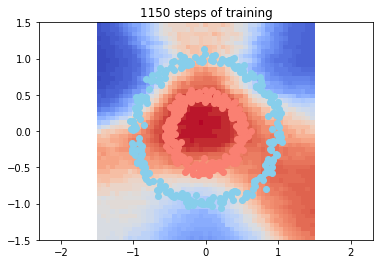

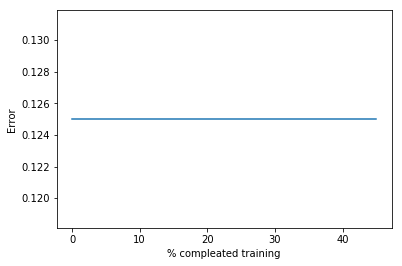

In [ ]:
from IPython.display import clear_output
set_posit_env(8, 0)
nn_posit = create_nn(topology, sigm2, posit=True)

loss = []
plot_NN(0, posit=True)
for i in range(1,2501):

    # Entrenemos a la red!
    pY = train(nn_posit, posify(X), posify(Y), l2_cost, lr=0.05)

    if i % 25 == 0:
#         print(pY)
        loss.append(l2_cost[0](pY, posify(Y)))

        plot_NN(i, posit=True)

        clear_output(wait=True)
        plt.show()
        plt.plot(range(len(loss)), loss)
        plt.xlabel('% compleated training')
        plt.ylabel('Error')
        plt.show()
#         time.sleep(0.5)  